# SWAN sensitivity example

In this notebook we will load the base config options from yaml file and define
different SWAN workspaces for different source terms to simulate sensitivity testing

In [1]:
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy
from pathlib import Path
import yaml
import shutil

import warnings
warnings.filterwarnings('ignore')

## Workspace basepath

In [2]:
workdir = Path("example_sensitivity")
shutil.rmtree(workdir, ignore_errors=True)
workdir.mkdir()

## Instantiate model

Use a fully-defined config from yaml to instantiate ModelRun with the runtime parameters
and the config definition

In [3]:
# Uncoment below to view the contents of the yaml file

# !cat example_sensitivity.yml

In [6]:
from rompy.swan.config import SwanConfigComponents

conf_dict = yaml.load(open("example_sensitivity.yml"), Loader=yaml.Loader)
config = SwanConfigComponents(**conf_dict)
config

SwanConfigComponents(model_type='swanconfig', template='/source/csiro/rompy/rompy/templates/swancomp', checkout='main', cgrid=REGULAR(model_type='regular', spectrum=SPECTRUM(model_type='spectrum', mdc=36, flow=0.04, fhigh=1.0, msc=None, dir1=None, dir2=None), grid=GRIDREGULAR(model_type='gridregular', xp=110.0, yp=-35.2, alp=4.0, xlen=7.5, ylen=12.5, mx=14, my=24, suffix='c')), startup=STARTUP(model_type='startup', project=PROJECT(model_type='project', name='Test sensitivity', nr='run1', title1='Source terms sensitivity testing', title2=None, title3=None), set=SET(model_type='set', level=0.0, nor=None, depmin=0.05, maxmes=None, maxerr=None, grav=None, rho=None, cdcap=None, inrhog=None, hsrerr=None, direction_convention='nautical', pwtail=None, froudmax=None, icewind=None), mode=MODE(model_type='mode', kind='nonstationary', dim='twodimensional'), coordinates=COORDINATES(model_type='coordinates', kind=SPHERICAL(model_type='spherical', projection='ccm'), reapeating=False)), inpgrid=DataIn

### Examine components

In [7]:
# Project

print(config.startup.project.render())

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing'


In [8]:
# Source terms

print(config.physics.gen.render())

GEN3 KOMEN cds2=2.3e-05 stpm=0.00302 DRAG WU


### Sensitivity config

In [9]:
def set_experiment(config, source_terms):
    """Return a new config object for a given experiment"""
    new_config = deepcopy(config)
    new_config.startup.project.title2 = f"Experiment {source_terms.model_type.upper()}"
    new_config.physics.gen.source_terms = source_terms
    return new_config

In [10]:
from rompy.core.time import TimeRange

period = TimeRange(
    start="2023-01-01T00:00:00",
    end="2023-01-02T00:00:00",
    interval="1h"
)

period

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=3600), include_end=True)

In [11]:
from rompy.model import ModelRun
from rompy.swan.subcomponents.physics import KOMEN, JANSSEN, WESTHUYSEN, ST6C1, ST6C2, ST6C3, ST6C4, ST6C5
runs = []
for component in [KOMEN, JANSSEN, WESTHUYSEN, ST6C1, ST6C2, ST6C3, ST6C4, ST6C5]:
    source_terms = component()
    run_id = f"{source_terms.model_type.lower()}"
    new_config = set_experiment(config, source_terms=source_terms)

    print(f"\n{new_config.startup.project.render()}")
    print(f"{new_config.physics.gen.source_terms.render()}")

    runs.append(ModelRun(
        run_id=run_id,
        config=new_config,
        period=period,
        output_dir=str(workdir)),
    )


PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment KOMEN'
KOMEN DRAG WU

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment JANSSEN'
JANSSEN DRAG WU

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment WESTHUYSEN'
WESTHUYSEN DRAG WU

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment ST6C1'
ST6 a1sds=4.7e-07 a2sds=6.6e-06 p1sds=4.0 p2sds=4.0 UP HWANG VECTAU U10PROXY windscaling=28.0 AGROW

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment ST6C2'
ST6 a1sds=4.7e-07 a2sds=6.6e-06 p1sds=4.0 p2sds=4.0 UP FAN VECTAU U10PROXY windscaling=28.0 AGROW

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment ST6C3'
ST6 a1sds=2.8e-06 a2sds=3.5e-05 p1sds=4.0 p2sds=4.0 UP HWANG VECTAU U10PROXY win

### Generate workspaces

In [12]:
for run in runs:
    run()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: komen
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: example_sensitivity
config: <class 'rompy.swan.config.SwanConfigComponents'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example_sensitivity
INFO:rompy.swan.data:	Writing bottom to example_sensitivity/komen/bottom.grd
INFO:rompy.swan.data:	Writing wind to example_sensitivity/komen/wind.grd
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in example_sensitivity
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: janssen
period: 
	Start: 2023-

### Check the workspace

In [13]:
modeldirs = sorted(workdir.glob("*"))
modeldirs

[PosixPath('example_sensitivity/janssen'),
 PosixPath('example_sensitivity/komen'),
 PosixPath('example_sensitivity/st6c1'),
 PosixPath('example_sensitivity/st6c2'),
 PosixPath('example_sensitivity/st6c3'),
 PosixPath('example_sensitivity/st6c4'),
 PosixPath('example_sensitivity/st6c5'),
 PosixPath('example_sensitivity/westhuysen')]

In [14]:
sorted(modeldirs[0].glob("*"))

[PosixPath('example_sensitivity/janssen/INPUT'),
 PosixPath('example_sensitivity/janssen/bottom.grd'),
 PosixPath('example_sensitivity/janssen/wind.grd')]

In [15]:
input = modeldirs[0] / "INPUT"
print(input.read_text())

! Rompy SwanConfig
! Template: /source/csiro/rompy/rompy/templates/swancomp
! Generated: 2025-01-28 06:49:11.790669 on rafael-XPS by rguedes


! Startup -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

PROJECT name='Test sensitivity' nr='run1' title1='Source terms sensitivity testing' title2='Experiment JANSSEN'

SET level=0.0 depmin=0.05 NAUTICAL

MODE NONSTATIONARY TWODIMENSIONAL

COORDINATES SPHERICAL CCM

! Computational Grid --------------------------------------------------------------------------------------------------------------------------------------------------------------


CGRID REGULAR xpc=110.0 ypc=-35.2 alpc=4.0 xlenc=7.5 ylenc=12.5 mxc=14 myc=24 CIRCLE mdc=36 flow=0.04 fhigh=1.0

! Input Grids ------------------------------------------------------------------------------------------------------------------------------------------------------------

## Run the model

In [16]:
for modeldir in modeldirs:
    cmd = ["docker", "run", "-v", f"./{modeldir}:/home", "oceanum/swan:4141", "swan.exe", ">", f"{modeldir}/swan.log"]
    print(" ".join(cmd))
    os.system(" ".join(cmd))

docker run -v ./example_sensitivity/janssen:/home oceanum/swan:4141 swan.exe > example_sensitivity/janssen/swan.log
docker run -v ./example_sensitivity/komen:/home oceanum/swan:4141 swan.exe > example_sensitivity/komen/swan.log
docker run -v ./example_sensitivity/st6c1:/home oceanum/swan:4141 swan.exe > example_sensitivity/st6c1/swan.log
docker run -v ./example_sensitivity/st6c2:/home oceanum/swan:4141 swan.exe > example_sensitivity/st6c2/swan.log
docker run -v ./example_sensitivity/st6c3:/home oceanum/swan:4141 swan.exe > example_sensitivity/st6c3/swan.log
docker run -v ./example_sensitivity/st6c4:/home oceanum/swan:4141 swan.exe > example_sensitivity/st6c4/swan.log
docker run -v ./example_sensitivity/st6c5:/home oceanum/swan:4141 swan.exe > example_sensitivity/st6c5/swan.log
docker run -v ./example_sensitivity/westhuysen:/home oceanum/swan:4141 swan.exe > example_sensitivity/westhuysen/swan.log


In [17]:
# Check for output files
for modeldir in modeldirs:
    print(sorted(modeldir.glob("*.nc")))

[PosixPath('example_sensitivity/janssen/swangrid.nc'), PosixPath('example_sensitivity/janssen/swanspec.nc')]
[PosixPath('example_sensitivity/komen/swangrid.nc'), PosixPath('example_sensitivity/komen/swanspec.nc')]
[PosixPath('example_sensitivity/st6c1/swangrid.nc'), PosixPath('example_sensitivity/st6c1/swanspec.nc')]
[PosixPath('example_sensitivity/st6c2/swangrid.nc'), PosixPath('example_sensitivity/st6c2/swanspec.nc')]
[PosixPath('example_sensitivity/st6c3/swangrid.nc'), PosixPath('example_sensitivity/st6c3/swanspec.nc')]
[PosixPath('example_sensitivity/st6c4/swangrid.nc'), PosixPath('example_sensitivity/st6c4/swanspec.nc')]
[PosixPath('example_sensitivity/st6c5/swangrid.nc'), PosixPath('example_sensitivity/st6c5/swanspec.nc')]
[PosixPath('example_sensitivity/westhuysen/swangrid.nc'), PosixPath('example_sensitivity/westhuysen/swanspec.nc')]


## Plot outputs

In [18]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from wavespectra import read_ncswan, read_swan
from wavespectra.core.swan import read_tab

pd.set_option("display.notebook_repr_html", False)

In [19]:
def read_gridded_output(run):
    """Read mean gridded output from a model run"""
    modeldir = Path(run.output_dir) / run.run_id
    dset = xr.open_dataset(modeldir / run.config.output.block.fname)
    return dset.mean("time")


def read_spectra_output(run):
    """Read mean spectra output from a model run"""
    modeldir = Path(run.output_dir) / run.run_id
    dset = read_ncswan(modeldir / run.config.output.specout.fname)
    return dset.mean("time")

In [20]:
# Gridded parameters

dsgrid = xr.concat([read_gridded_output(run) for run in runs], dim="source_terms")
dsgrid["source_terms"] = [run.run_id for run in runs]
dsgrid

<xarray.Dataset> Size: 75kB
Dimensions:       (source_terms: 8, yc: 25, xc: 15)
Coordinates:
    longitude     (yc, xc) float32 2kB 110.0 110.5 111.1 ... 115.5 116.1 116.6
    latitude      (yc, xc) float32 2kB -35.2 -35.16 -35.13 ... -22.24 -22.21
  * source_terms  (source_terms) <U10 320B 'komen' 'janssen' ... 'st6c4' 'st6c5'
Dimensions without coordinates: yc, xc
Data variables:
    depth         (source_terms, yc, xc) float32 12kB 4.824e+03 4.16e+03 ... nan
    xwnd          (source_terms, yc, xc) float32 12kB -0.8986 -1.029 ... nan nan
    ywnd          (source_terms, yc, xc) float32 12kB 6.718 6.65 ... nan nan
    hs            (source_terms, yc, xc) float32 12kB 1.019 0.6307 ... nan nan
    tps           (source_terms, yc, xc) float32 12kB 11.66 11.66 ... nan nan
    theta0        (source_terms, yc, xc) float32 12kB 255.5 291.2 ... nan nan

In [21]:
# Wave spectra

dspec = xr.concat([read_spectra_output(run) for run in runs], dim="source_terms")
dspec["source_terms"] = [run.run_id for run in runs]
dspec

<xarray.Dataset> Size: 122kB
Dimensions:       (source_terms: 8, site: 3, freq: 35, dir: 36)
Coordinates:
  * freq          (freq) float32 140B 0.04 0.04397 0.04834 ... 0.8275 0.9097 1.0
  * dir           (dir) float32 144B 261.0 251.0 241.0 ... 291.0 281.0 271.0
  * site          (site) int64 24B 1 2 3
  * source_terms  (source_terms) <U10 320B 'komen' 'janssen' ... 'st6c4' 'st6c5'
Data variables:
    lon           (source_terms, site) float32 96B dask.array<chunksize=(1, 3), meta=np.ndarray>
    lat           (source_terms, site) float32 96B dask.array<chunksize=(1, 3), meta=np.ndarray>
    efth          (source_terms, site, freq, dir) float32 121kB dask.array<chunksize=(1, 3, 35, 36), meta=np.ndarray>
    dpt           (source_terms, site) float32 96B dask.array<chunksize=(1, 3), meta=np.ndarray>
    wspd          (source_terms, site) float32 96B dask.array<chunksize=(1, 3), meta=np.ndarray>
    wdir          (source_terms, site) float32 96B dask.array<chunksize=(1, 3), meta=np.ndarray>

### Gridded parameters

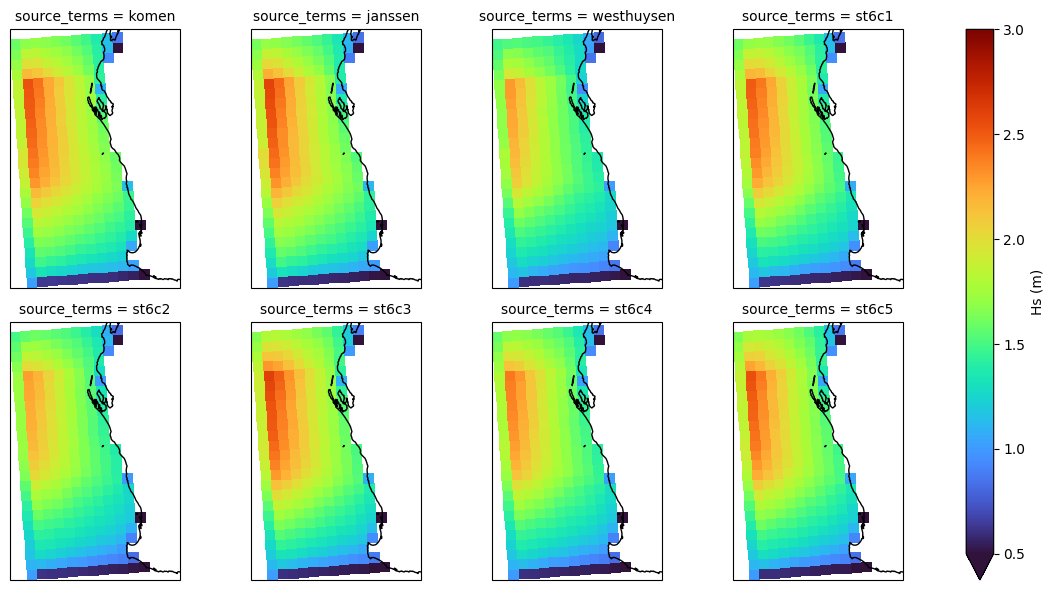

In [22]:
f = dsgrid.hs.plot(
    x="longitude",
    y="latitude",
    col="source_terms",
    col_wrap=4,
    vmin=0.5,
    vmax=3.0,
    cmap="turbo",
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    cbar_kwargs=dict(label="Hs (m)"),
)
f.map(lambda: plt.gca().coastlines());

### Wave spectra

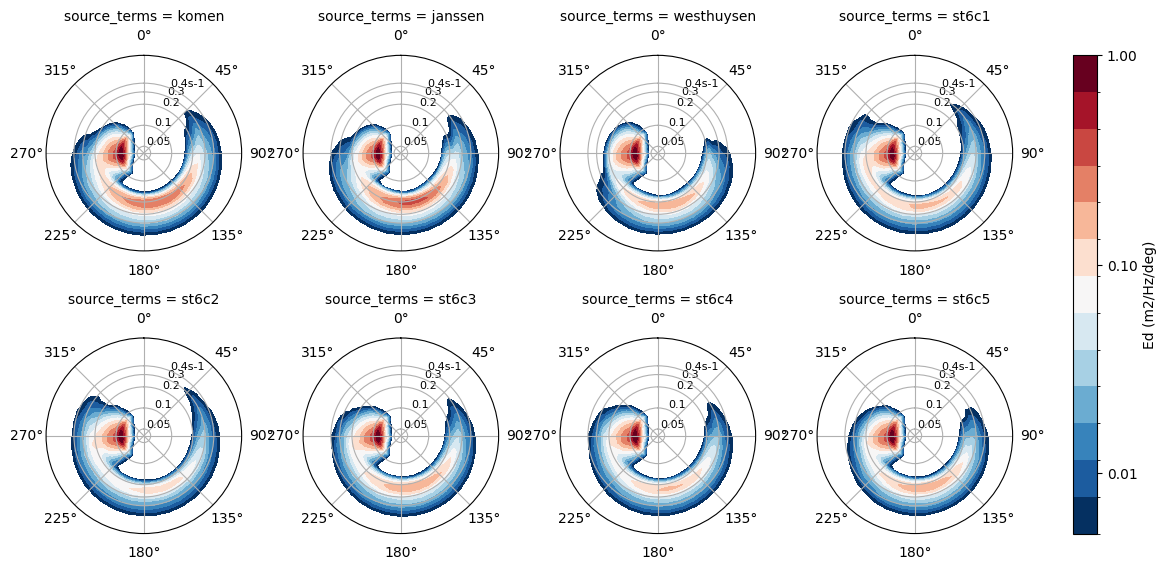

In [23]:
p = dspec.isel(site=0).spec.plot(col="source_terms", col_wrap=4, cbar_kwargs={"label": "Ed (m2/Hz/deg)"})